### Links to Reference

[Keras Multi Output Model](https://github.com/rodrigobressan/keras-multi-output-model-utk-face/blob/master/notebook.ipynb)

[Keras Documentation - Functional API](https://keras.io/guides/functional_api/)

[Stack Overflow - How to Implement Multilabel Classification with UTKFace](https://stackoverflow.com/questions/66852823/how-to-implement-multilabel-classification-on-utkface-dataset-using-tensorflow-a)

[Tensorflow Guide - Keras Train and Evaluate](https://www.tensorflow.org/guide/keras/train_and_evaluate)

[Stack Overflow - Keras Value Error with Dimensions](https://stackoverflow.com/questions/61069068/keras-valueerror-dimensions-must-be-equal-but-are-6-and-9-for-node-equal)

[Helpful Guide for Age + Gender Detection Using DL](https://www.analyticsvidhya.com/blog/2021/07/age-and-gender-detection-using-deep-learning/ )

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import cv2

### Image Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

**age** is an integer from 0 to 116, indicating the age

**gender** is either 0 (male) or 1 (female)

**race** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

**date&time** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [2]:
dataset_dict = {
    'race_id': {
        0: 'White', 
        1: 'Black', 
        2: 'Asian', 
        3: 'Indian', 
        4: 'Others'
    },
    'gender_id': {
        0: 'Male',
        1: 'Female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

dataset_dict

{'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'},
 'gender_id': {0: 'Male', 1: 'Female'},
 'gender_alias': {'Male': 0, 'Female': 1},
 'race_alias': {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}}

### Loading Data into Text and CSV Files

In [3]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [4]:
def parse_dataset_raw(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_raw_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), int(gender), int(race)
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_raw_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [5]:
dataset_path = "UTKFace"
df = parse_dataset(dataset_path)
df

,Age,Gender,Race,File
0,9.0,Female,Asian,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,Male,Black,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,Female,White,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,Female,White,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,Female,Asian,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,Male,White,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,Male,Indian,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,Male,Black,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,Male,Black,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [6]:
df_raw = parse_dataset_raw(dataset_path)
df_raw

,Age,Gender,Race,File
0,9.0,1.0,2.0,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,0.0,1.0,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,1.0,0.0,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,1.0,0.0,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,1.0,2.0,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,0.0,0.0,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,0.0,3.0,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,0.0,1.0,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,0.0,1.0,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [7]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img = fig.to_image(format="png")
    display(Image(img))

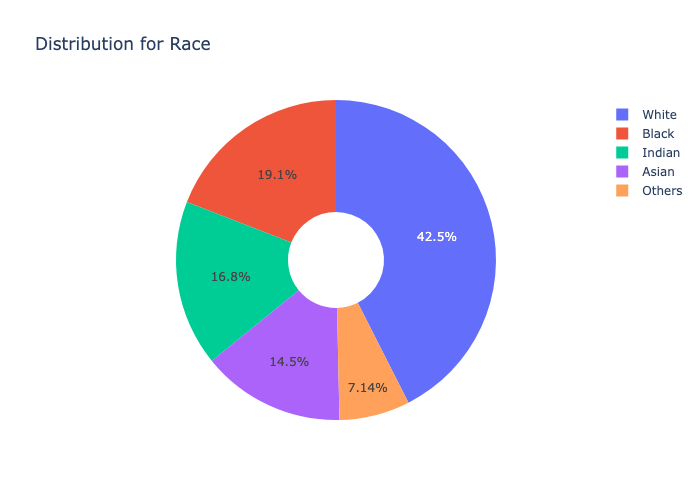

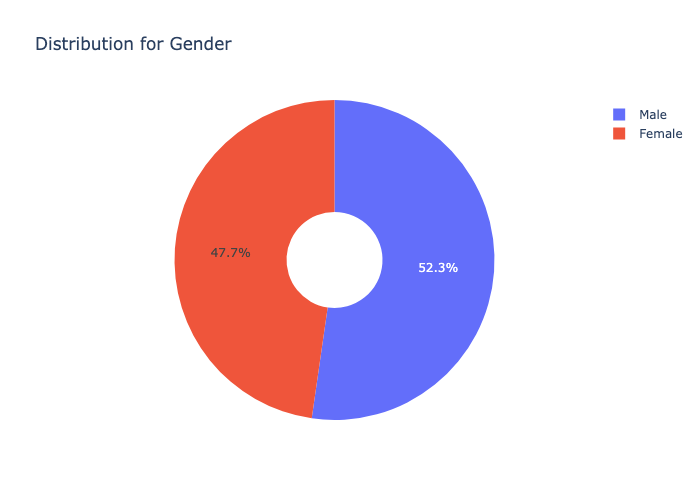

In [8]:
plot_distribution(df["Race"])
plot_distribution(df["Gender"])

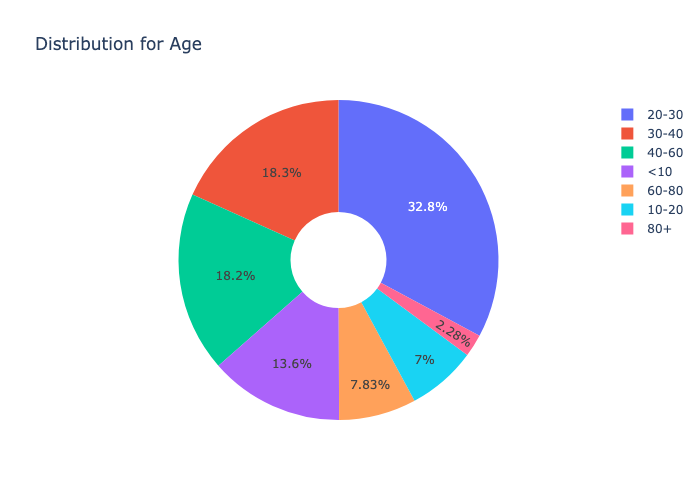

In [9]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['Age'], bins, labels=names)
plot_distribution(age_binned)


In [10]:
ages = df_raw["Age"].tolist()
genders = df_raw["Gender"].tolist()
print(len(ages))
print(len(genders))

23705
23705


In [11]:
files = df_raw["File"].tolist()
print(len(files))

images = []
for file in files: 
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(48,48))
    
    images.append(image)

print(len(images))

23705
23705


In [12]:
labels = []

for i in range(len(ages)):
    label = []
    label.append(ages[i])
    label.append(genders[i])

    labels.append(label)

print(len(labels))
print(labels[0])

23705
[9.0, 1.0]


In [13]:
labels = np.array(labels)
images = np.array(images)
print(labels.shape)
print(images.shape)

(23705, 2)
(23705, 48, 48, 3)


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(18964, 48, 48, 3)
(4741, 48, 48, 3)
(18964, 2)
(4741, 2)


In [17]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [18]:
def Convolution(input_tensor,filters):
  x = Conv2D(filters = filters, kernel_size = (3, 3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(0.001))(input_tensor)
  x = Dropout(0.1)(x)
  x = Activation('relu')(x)
  return x

def model(input_shape):
  inputs = Input((input_shape))
  conv_1 = Convolution(inputs, 32)
  maxp_1 = MaxPooling2D(pool_size = (2, 2)) (conv_1)
  conv_2 = Convolution(maxp_1, 64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2, 128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3, 256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten = Flatten() (maxp_4)
  dense_1 = Dense(64, activation = 'relu')(flatten)
  dense_2 = Dense(64, activation = 'relu')(flatten)
  drop_1 = Dropout(0.2)(dense_1)
  drop_2 = Dropout(0.2)(dense_2)
  output_1 = Dense(1, activation = "relu", name = 'age_out')(drop_1)
  output_2 = Dense(1,activation="sigmoid",name='sex_out')(drop_2)

  model = Model(inputs = [inputs], outputs = [tf.concat([output_1,output_2], 1)])
  model.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), metrics = ["accuracy"])

  return model



In [19]:
test_model = model((48, 48, 3))
test_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   896         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 48, 48, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['dropout[0][0]']                
                 

2022-05-23 16:12:04.054613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-23 16:12:04.054826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
History = test_model.fit(x_train, y_train, batch_size=64, validation_data = [x_test, y_test], epochs = 5)

Epoch 1/5


2022-05-23 16:12:04.341083: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-23 16:12:04.707700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


297/297 [==============================] - ETA: 0s - loss: 8.6901 - accuracy: 0.9985

2022-05-23 16:12:16.522411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


297/297 [==============================] - 13s 41ms/step - loss: 8.6901 - accuracy: 0.9985 - val_loss: 9.4359 - val_accuracy: 1.0000
Epoch 2/5
297/297 [==============================] - 12s 40ms/step - loss: 7.8621 - accuracy: 1.0000 - val_loss: 9.1229 - val_accuracy: 1.0000
Epoch 3/5
297/297 [==============================] - 12s 39ms/step - loss: 7.4160 - accuracy: 0.9999 - val_loss: 8.8927 - val_accuracy: 0.9998
Epoch 4/5
297/297 [==============================] - 12s 40ms/step - loss: 7.0711 - accuracy: 0.9997 - val_loss: 8.8306 - val_accuracy: 0.9996
Epoch 5/5
297/297 [==============================] - 12s 40ms/step - loss: 6.7860 - accuracy: 0.9989 - val_loss: 8.5298 - val_accuracy: 0.9966


27.0
1.0
[[2.9302057e+01 2.2357230e-05]]


2022-05-23 16:13:04.857050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


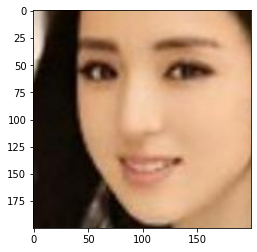

In [21]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(files))

file = files[idx]
file = cv2.imread(file)
file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)

plt.imshow(file)

def test_image(idx, Model):
  file = files[idx]
  file = cv2.imread(file)
  file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)
  file = cv2.resize(image, (48, 48))
  file = np.reshape(file, (1, 48, 48, 3))

  age = ages[idx]
  gender = genders[idx]
  print(age)
  print(gender)

  print(test_model.predict(file))
  
test_image(idx, Model)
